In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


#### DL

In [2]:
# Seed 고정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# 데이터 로드
file_path = 'sliced_data.csv'
df = pd.read_csv(file_path)

# X, y 데이터 생성
X = df[['L ankle JC', 'L ankle JC.1', 'L ankle JC.2', 'L elbow JC', 'L elbow JC.1', 'L elbow JC.2', 'L knee JC', 'L knee JC.1', 'L knee JC.2', 
        'R ankle JC', 'R ankle JC.1', 'R ankle JC.2', 'R elbow JC', 'R elbow JC.1', 'R elbow JC.2', 'R knee JC', 'R knee JC.1', 'R knee JC.2',]].values

y = df['binary'].values


In [3]:
print(X.shape)

(320052, 18)


In [4]:
# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time_steps = 50
features = 18

# MANY to ONE 형식의 데이터 생성
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - time_steps + 1):
    X_sequences.append(X_scaled[i:i + time_steps])
    y_sequences.append(y[i + time_steps - 1])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 클래스별 인덱스 분리 및 다운샘플링
class_0_indices = np.where(y_sequences == 0)[0]
class_1_indices = np.where(y_sequences == 1)[0]
class_0_downsampled = resample(class_0_indices,
                               replace=False,
                               n_samples=len(class_1_indices),
                               random_state=42)

# 다운샘플링된 데이터셋 병합
resampled_indices = np.hstack([class_0_downsampled, class_1_indices])

# 새로운 데이터셋 생성
X_resampled = X_sequences[resampled_indices]
y_resampled = y_sequences[resampled_indices]

# 훈련 데이터와 테스트 데이터로 분리 (StratifiedShuffleSplit 사용)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X_resampled, y_resampled))
X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

# 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# 조기 종료 클래스 정의
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# 모델 학습 및 평가 함수
def train_and_evaluate(model, train_loader, test_loader, num_epochs=50, patience=3):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 조기 종료 객체 생성
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

        # 검증 손실 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                val_loss += loss.item()
        val_loss /= len(test_loader)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')

        # 조기 종료 확인
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # 조기 종료 시 저장된 최상의 모델 가중치 로드
    model.load_state_dict(early_stopping.best_model_wts)

    # 모델 평가
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()

            # y_true와 y_pred 리스트에 실제 값과 예측 값을 추가
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.squeeze().tolist())
            y_scores.extend(outputs.squeeze().tolist())

            total += y_batch.size(0)
            correct += (predicted.squeeze() == y_batch).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    
    return accuracy, y_true, y_pred, y_scores

# 모델 학습 및 평가 수행
input_size = features
hidden_size = 256
num_layers = 2
dropout = 0.2

models = {
    "LSTM": LSTMModel(input_size, hidden_size, num_layers, dropout),
    "GRU": GRUModel(input_size, hidden_size, num_layers, dropout)
}

results = {}

for model_name, model in models.items():
    print(f"Training and evaluating {model_name} model...")
    accuracy, y_true, y_pred, y_scores = train_and_evaluate(model, train_loader, test_loader)
    results[model_name] = {
        "accuracy": accuracy,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_scores": y_scores
    }
    print(f'{model_name} Test Accuracy: {accuracy:.4f}\n')

Training and evaluating LSTM model...
Epoch 1/50, Loss: 0.4860931634902954, Val Loss: 0.5538260638713837
Epoch 2/50, Loss: 0.1937338262796402, Val Loss: 0.32066653420527774
Epoch 3/50, Loss: 0.0658903419971466, Val Loss: 0.20980376501878104
Epoch 4/50, Loss: 0.47484105825424194, Val Loss: 0.2833103785912196
EarlyStopping counter: 1 out of 3
Epoch 5/50, Loss: 0.23349793255329132, Val Loss: 0.23996527244647345
EarlyStopping counter: 2 out of 3
Epoch 6/50, Loss: 0.19524696469306946, Val Loss: 0.18863718460003534
Epoch 7/50, Loss: 0.1717786192893982, Val Loss: 0.17215218394994736
Epoch 8/50, Loss: 0.18792948126792908, Val Loss: 0.15140016873677573
Epoch 9/50, Loss: 0.2152971625328064, Val Loss: 0.1568113515774409
EarlyStopping counter: 1 out of 3
Epoch 10/50, Loss: 0.08483457565307617, Val Loss: 0.14938677102327347
Epoch 11/50, Loss: 0.09875641018152237, Val Loss: 0.13876475021243095
Epoch 12/50, Loss: 0.11998573690652847, Val Loss: 0.17130300775170326
EarlyStopping counter: 1 out of 3
Epo

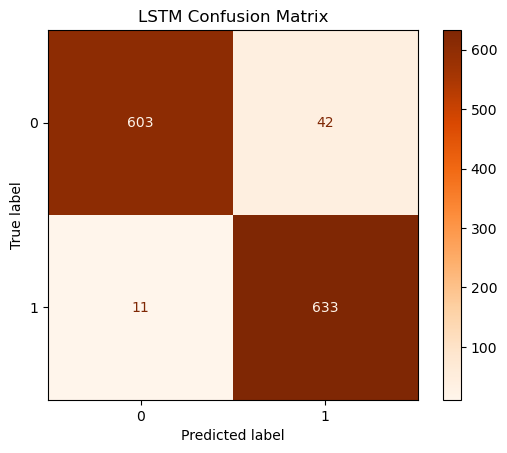

LSTM Performance:
True Negatives (TN): 603
False Positives (FP): 42
False Negatives (FN): 11
True Positives (TP): 633

Class 0 - Precision: 0.9821, Recall: 0.9349, F1 Score: 0.9579
Class 1 - Precision: 0.9378, Recall: 0.9829, F1 Score: 0.9598




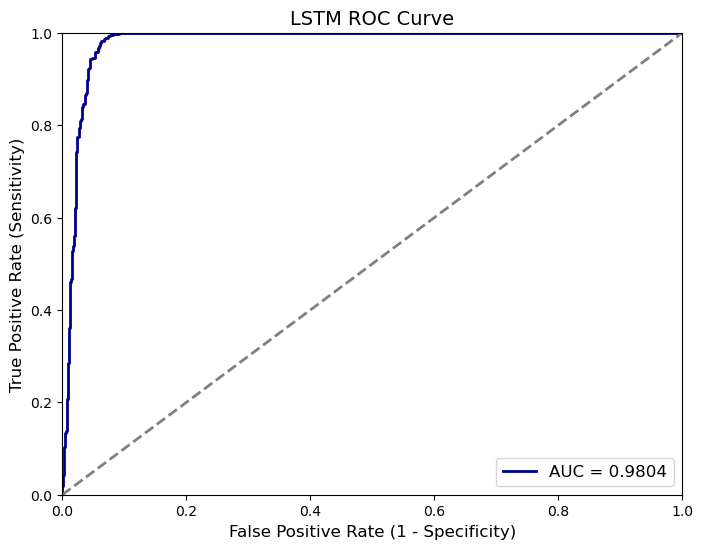

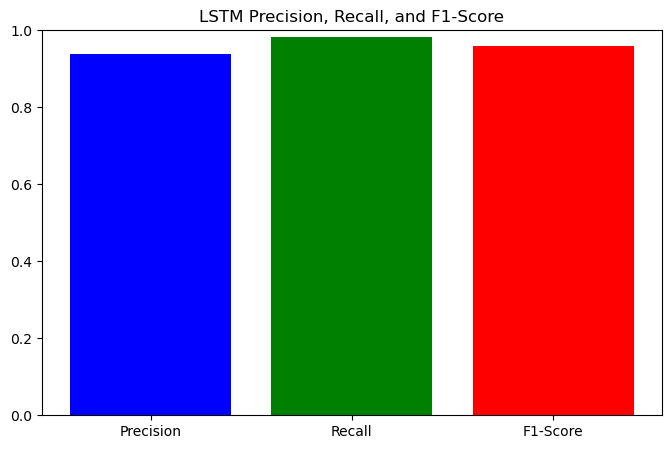

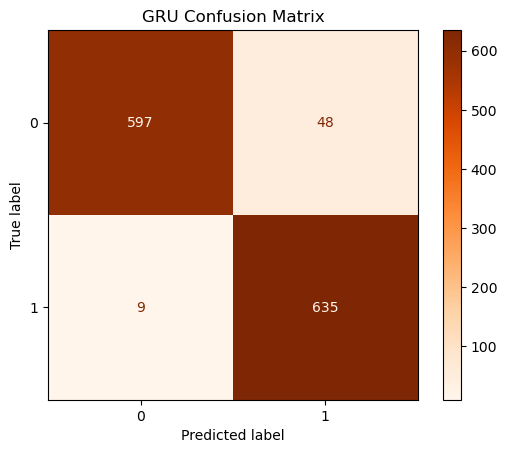

GRU Performance:
True Negatives (TN): 597
False Positives (FP): 48
False Negatives (FN): 9
True Positives (TP): 635

Class 0 - Precision: 0.9851, Recall: 0.9256, F1 Score: 0.9544
Class 1 - Precision: 0.9297, Recall: 0.9860, F1 Score: 0.9570




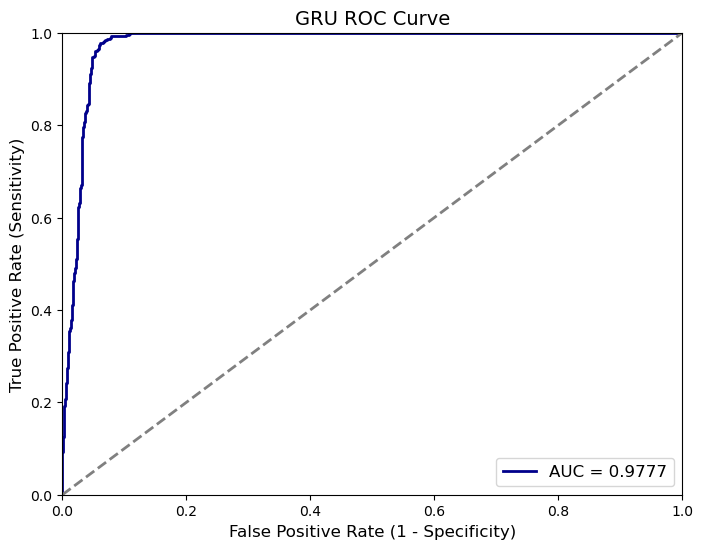

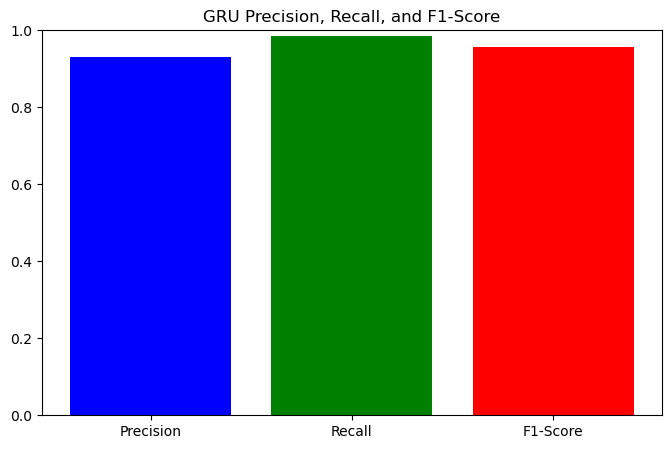

In [5]:
## 시각화 재작성 코드 
# sns.heatmap을 통해 생성된 Confusion Matrix가 단순히 전체 행렬을 시각화하는 데 그치기 때문에 표시 안됨
# 해당 값들을 직접 추출하여 출력해주기로 수정
# annot=True 옵션을 사용하면서, 각 셀에 들어갈 텍스트 내용을 지정 

# 성능 평가 및 시각화
for model_name, result in results.items():
    y_true = result["y_true"]
    y_pred = result["y_pred"]
    y_scores = result["y_scores"]
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Oranges)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # Confusion Matrix 값을 출력
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f'{model_name} Performance:')
    print(f'True Negatives (TN): {tn}')
    print(f'False Positives (FP): {fp}')
    print(f'False Negatives (FN): {fn}')
    print(f'True Positives (TP): {tp}\n')
    
    # 각 클래스의 정밀도(precision), 재현율(recall), F1 점수 계산
    precision_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]) if (conf_matrix[0, 0] + conf_matrix[1, 0]) != 0 else 0
    recall_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) != 0 else 0
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) != 0 else 0

    precision_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]) if (conf_matrix[1, 1] + conf_matrix[0, 1]) != 0 else 0
    recall_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) != 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) != 0 else 0
    
    print(f'Class 0 - Precision: {precision_0:.4f}, Recall: {recall_0:.4f}, F1 Score: {f1_0:.4f}')
    print(f'Class 1 - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1 Score: {f1_1:.4f}')
    print('\n')
    
    
    # ROC Curve and AUC
    plt.style.use('seaborn-v0_8-dark-palette')
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title(f'{model_name} ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Precision, Recall, F1-Score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }
    
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title(f'{model_name} Precision, Recall, and F1-Score')
    plt.show()